In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [3]:
train.shape, test.shape

((1821, 5), (1821, 1))

In [4]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [5]:
test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [6]:
submission.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


In [7]:
healthy = train.loc[train['healthy']==1]
multiple_diseases = train.loc[train['multiple_diseases']==1]
rust = train.loc[train['rust']==1]
scab = train.loc[train['scab']==1]

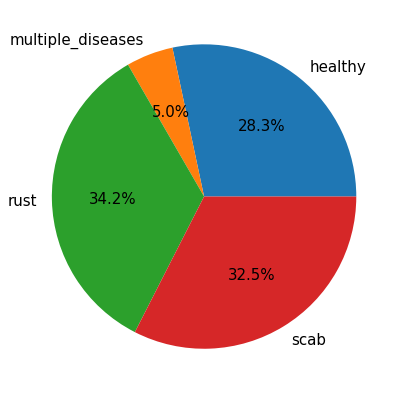

In [8]:
mpl.rc('font',size=15)
plt.figure(figsize=(7, 7))

label = ['healthy','multiple_diseases','rust','scab']

plt.pie([len(healthy),len(multiple_diseases),len(rust),len(scab)],labels=label,autopct='%.1f%%');

In [9]:
import matplotlib.gridspec as gridspec
import cv2

In [10]:
def show_image(img_ids, rows=2, cols=3):
    assert len(img_ids) <= rows * cols # 이미지가 행/열 개수보다 많으면 오류 발생
    
    plt.figure(figsize=(15,8))
    grid = gridspec.GridSpec(rows, cols)
    
    for idx, img_id in enumerate(img_ids):
        img_path = f'images/{img_id}.jpg'
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(grid[idx])
        ax.imshow(image)
        plt.axis('off')

In [11]:
num_of_imgs = 6
last_healthy_img_ids = healthy['image_id'][-num_of_imgs:]
last_multiple_diseases_img_ids = multiple_diseases['image_id'][-num_of_imgs:]
last_rust_img_ids = rust['image_id'][-num_of_imgs:]
last_scab_img_ids = scab['image_id'][-num_of_imgs:]

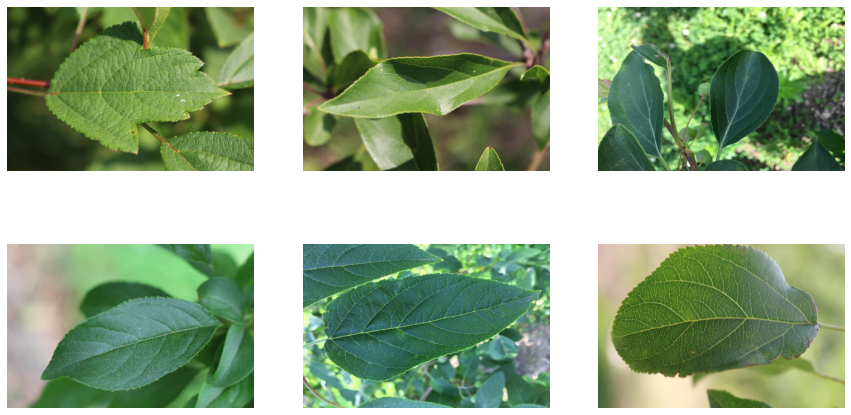

In [12]:
show_image(last_healthy_img_ids) # 건강한 잎사귀 출력

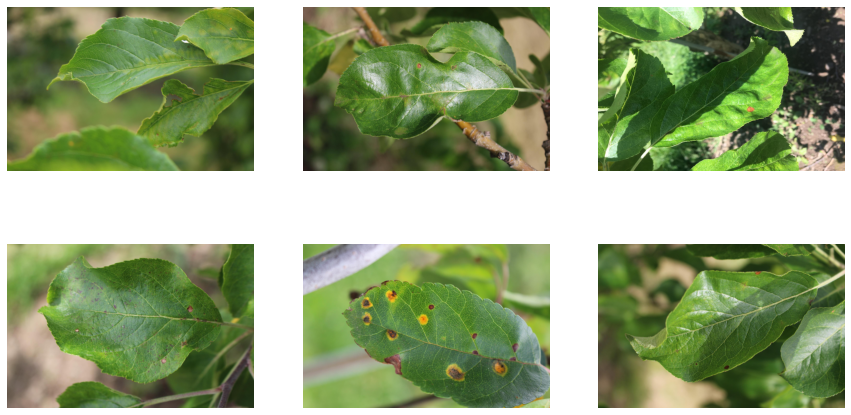

In [13]:
show_image(last_multiple_diseases_img_ids) # 여러 질병에 걸린 잎사귀 출력

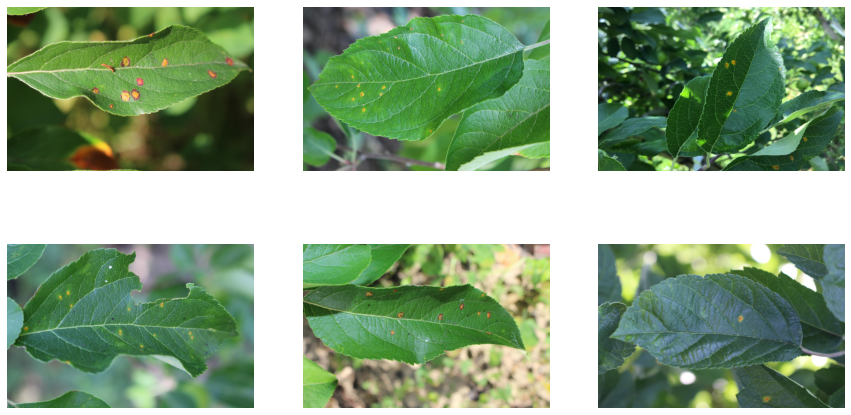

In [14]:
show_image(last_rust_img_ids) # 녹병에 걸린 잎사귀 출력

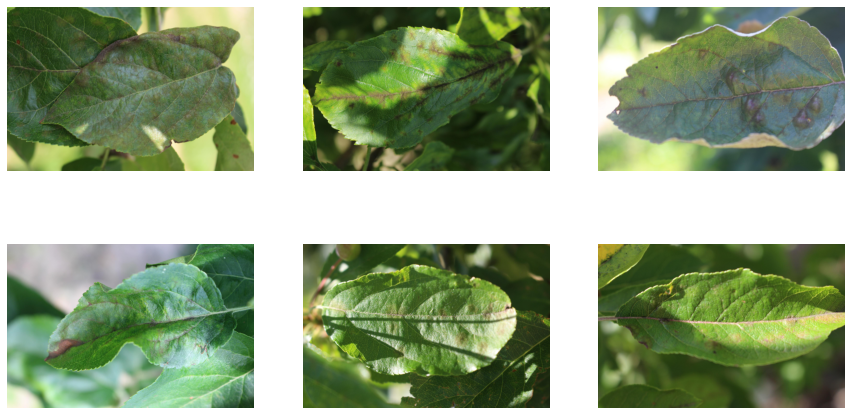

In [15]:
show_image(last_scab_img_ids) # 붉은곰팡이병에 걸린 잎사귀

In [16]:
import torch
import random
import numpy as np
import os

In [17]:
# 시드값 고정
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed) 
random.seed(seed)                          # 파이썬 난수 생성기 시드 고정
np.random.seed(seed)                       # 넘파이 난수 생성기 시드 고정
torch.manual_seed(seed)                    # 파이토치 난수 생성기 시드 고정(CPU 사용 시)
torch.cuda.manual_seed(seed)               # 파이토치 난수 생성기 시드 고정(GPU 사용 시)
torch.cuda.manual_seed_all(seed)           # 파이토치 난수 생성기 시드 고정(멀티 GPU 사용 시)
torch.backends.cudnn.deterministic = True # 확정적 연산 사용
torch.backends.cudnn.benchmark = False    # 벤치마크 기능 해제
torch.backends.cudnn.enable = False       # cudnn 사용 해제

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

In [19]:
import pandas as pd

In [20]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [21]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train,
                               test_size=0.1,
                               stratify=train[['healthy','multiple_diseases','rust','scab']],
                               random_state=50)

In [22]:
import cv2
from torch.utils.data import Dataset
import numpy as np

In [23]:
class ImageDataset(Dataset):
    def __init__(self, df, img_dir='./', transform=None, is_test=False):
        super().__init__()
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx,0]
        img_path = self.img_dir+img_id+'.jpg'
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            image = self.transform(image=image)['image'] 
        # 테스트 데이터면 이미지 데이터만 반환, 그렇지 않으면 타깃값도 반환
        if self.is_test:
            return image
        else:
            # 타깃값 4개 중 가장 큰 값은 인덱스
            label = np.argmax(self.df.iloc[idx, 1:5])
        return image, label # 훈련/검증용 일때

In [24]:
# pip install -U albumentations

In [25]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

D:\Anaconda\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'D:\Anaconda\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [26]:
transform_train = A.Compose([
    A.Resize(450, 650), # 이미지 크기 조절
    A.RandomBrightnessContrast(brightness_limit=0.2, # 밝기 대비 조절
                              contrast_limit=0.2, p=0.3),
    A.VerticalFlip(p=0.2),    # 상하 대칭 변환
    A.HorizontalFlip(p=0.5),  # 좌우 대칭 변환
    A.ShiftScaleRotate(       # 이동, 스케일링, 회전 변환
        shift_limit=0.1,
        scale_limit=0.2,
        rotate_limit=30, p=0.3),
    A.OneOf([A.Emboss(p=1), # 양각화, 날카로움, 블러 효과
             A.Sharpen(p=1),
             A.Blur(p=1)],p=0.3),
    A.PiecewiseAffine(p=0.3), # 어파인 변환
    A.Normalize(), # 정규화 변환
    ToTensorV2() # 텐서로 변환
])

In [27]:
transform_test = A.Compose([
    A.Resize(450, 650),  # 크기 조절
    A.Normalize(),       # 정규화 
    ToTensorV2()         # 텐서로 변환
])

In [28]:
img_dir = 'images/'

dataset_train = ImageDataset(train, img_dir=img_dir, transform=transform_train)
dataset_valid = ImageDataset(valid, img_dir=img_dir, transform=transform_test)

In [29]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

In [30]:
from torch.utils.data import DataLoader # 데이터 로더 생성을 위한 클래스

In [31]:
batch_size = 4

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker,generator=g, num_workers=2)
loader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker,generator=g, num_workers=2)

In [32]:
# !pip install efficientnet-pytorch==0.7.1

In [33]:
from efficientnet_pytorch import EfficientNet # EfficientNet 모델

In [34]:
model = EfficientNet.from_pretrained('efficientnet-b7',num_classes=4)
model = model.to(device)

Loaded pretrained weights for efficientnet-b7


In [35]:
import torch.nn as nn # 신경망 모듈

# 손실 함수
criterion = nn.CrossEntropyLoss()

In [36]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006, weight_decay=0.0001)

In [37]:
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm

In [ ]:
epochs = 5

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    
    for images, labels in tqdm(loader_train):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f'에폭[{epoch+1}/{epochs}] - 훈련 데이터손실값 : {ephoch_train_loss/len(loader_train):.4f}')
    
    model.eval()
    epoch_valid_loss = 0
    preds_list = []
    true_onehot_list = []
    
    with torch.no_grad():
        for images, labels in loader_valid:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_valid_loss += loss.item()
            
            preds = torch.softmax(outputs.cpu(),dim=1).numpy()
            
            true_onehot = torch.eye(4)[labels].cpu().numpy()
            
            preds_list.extend(preds)
            true_onehot_list.extend(true_onehot)
        print(f'에폭[{epoch+1}/{epochs}] - 검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f} / 검증 데이터 ROC AUC : {roc_auc_score(true_onehot_list,preds_list):.4f}')

  0%|          | 0/410 [00:00<?, ?it/s]